# **INFO-6147 | Deep Learning with Pytorch**

# **Project**

Debora Almeida Tesserolli

**GTZAN Dataset - Music Genre Classification**

## Motivation

The identification and understanding of sound are an important activity in several challenges in the context of multimedia processing, since music is present in people's daily lives, there are countless musical genres, and each person has their preference. A tool that helps in the task of automatically classifying musical genres can transform the user experience and open the possibility of building personalized recommendations.

## Main goal

The main objective is to automatically classify musical genres from audio files. For this task, a dataset called [GTZAN](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification), known as the MINIST of audio files, was made available.

The dataset consists of 1,000 audios of 30 seconds each. In total, there are 10 different styles: `blues`, `classical music`, `country`, `disco`, `hip hop`, `jazz`, `metal`, `pop`, `reggae`, and `rock`, with 100 audios for each class.
The dataset has three types of audio representations:
- Original Audios: a collection of 10 genres with 100 audio files each, all with a length of 30 seconds.
- Images: a visual representation for each 30s audio file.
- Feature files: these files contain features from the audio files for 30s and 3s.

For this project, only the image dataset will be considered.


Obs.: In this project, only GPU was used.




## Loading libraries

In [ ]:
# Libraries

import os
from zipfile import ZipFile
import time
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, f1_score
from sklearn.metrics import classification_report

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset

Environment setup with Colab

In [ ]:
# google drive + colab

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Pre Preprocessing

Define dataset path

In [ ]:
# define dataset location
dataset_path = '/content/gdrive/MyDrive/Fanshawe/Winter 2024/Deep Learning Pytorch/Project'

# destination folder to extract the files
dest_folder = dataset_path + '/data'

Unzip the files.

**The code below only needs to be generated once and adjust the path.**

In [ ]:
# ------- RUN JUST ONE TIME! -------

# define dataset location
# dataset_path = '/content/gdrive/MyDrive/Fanshawe/Winter 2024/Deep Learning Pytorch/Project'

# destination folder to extract the files
# dest_folder = dataset_path + '/data'

# create destination folder if it doesn't exist
# os.makedirs(dest_folder, exist_ok=True)

# zf = ZipFile(dataset_path + '/Data.zip', 'r')
# zf.extractall(dest_folder)
# zf.close()

In [ ]:
# images path
data_path = dest_folder + '/images_original/'

# labels
classes = sorted(os.listdir(data_path))

# list for storing images and labels
file_name = []
labels = []

for i in classes:
    class_dir = data_path + i
    for img_name in os.listdir(class_dir):
        img_path = class_dir + img_name
        file_name.append(img_path)
        labels.append(i)

In [ ]:
seed = 5
numclass = 10
image_size = 224
batch_size = 10

class_idx = dict(enumerate(classes))

Defining the transformations for loading the data.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),])

dataset = datasets.ImageFolder(root=data_path, transform=transform)

## Split dataset

Splitting dataset into train (80%), validation(10%) and test(10%).

The stratify option was used to maintain the same proportion of responses from the original data for the rest of the sets.

In [ ]:
# stratified sampling for train, val and test
train_idx, val_idx = train_test_split(np.arange(len(labels)), test_size=0.2, random_state=seed, shuffle=True, stratify=labels)
val_labels = [labels[i] for i in val_idx]
val_idx, test_idx = train_test_split(val_idx, test_size=0.5, random_state=seed, shuffle=True, stratify=val_labels)

# subset dataset for train, val and test
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Images

Viewing an image from each class.

In [ ]:
def show_images(dataset_loader, classes):
  labels_uniq = set()
  total_images = 0

  fig, axes = plt.subplots(2, 5, figsize=(15, 6))

  for images, labels in dataset_loader:
    for image, label in zip(images, labels):
      label = label.item()
      if label not in labels_uniq and total_images < 10:
        row_idx = len(labels_uniq) // 5
        col_idx = len(labels_uniq) % 5
        axes[row_idx, col_idx].imshow(image.permute(1, 2, 0))
        axes[row_idx, col_idx].set_title(classes[label])
        axes[row_idx, col_idx].axis('off')

        labels_uniq.add(label)
        total_images += 1

        if total_images >= 10:
          break
    if total_images >= 10:
      break
  plt.tight_layout()
  plt.show()

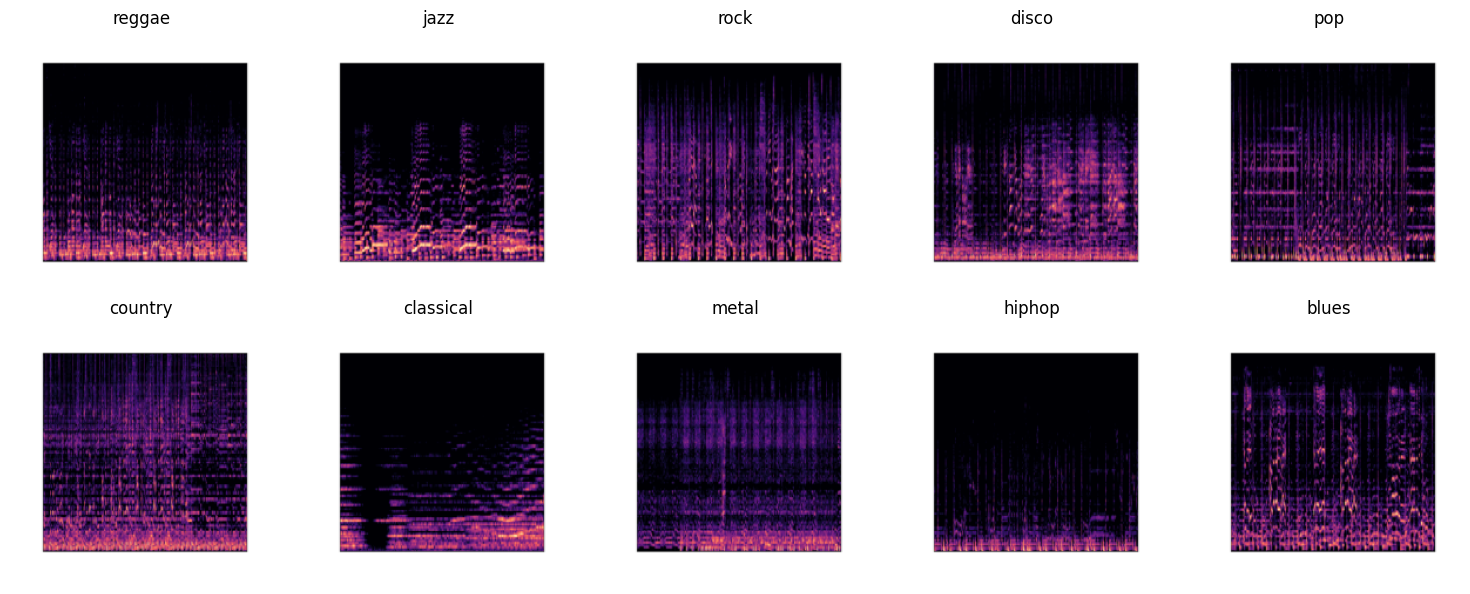

In [ ]:
show_images(train_loader, classes)

Analyzing the distribution of classes.

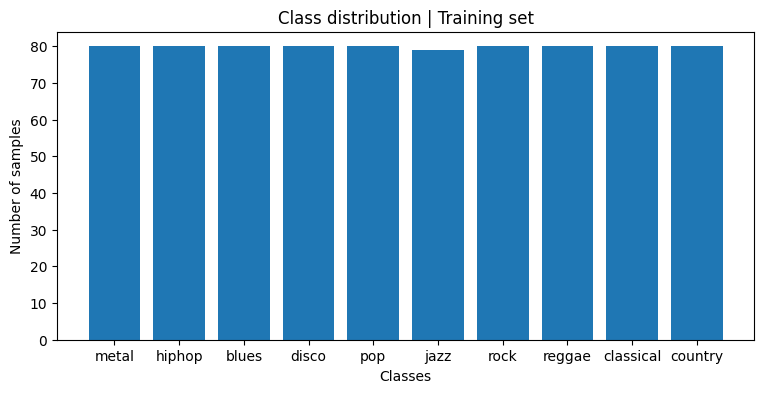

In [ ]:
class_count = dict()
for _, label in train_dataset:
  class_count[label] = class_count.get(label, 0) + 1

class_names = dataset.classes
class_count = {class_names[label]: count for label, count in class_count.items()}

plt.figure(figsize=(9, 4))
plt.bar(class_count.keys(), class_count.values())
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Class distribution | Training set')
plt.show()

It is possible to notice that the dataset is balanced.
Only one `jazz` class file is missing, but it does not compromise class balance.

## Bulding a model

### CNN Baseline

A Convolutional Neural Networks (CNN) was built as a baseline, which constitutes 3 convolutional layers followed by ReLU activation function followed by max pooling of size 2x2.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=0)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=0)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=0)
        self.fc1 = nn.Linear(64 * 26 * 26, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [ ]:
model_cnn = CNN()

Learning rate of 0.001 will be considered and optimizer Adam.

In [ ]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=learning_rate)

### Training the model

In [ ]:
num_epochs = 30
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in tqdm(range(num_epochs)):
    model_cnn.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # evaluate the model on the validation
    model_cnn.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model_cnn(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(test_loader.dataset)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

  3%|▎         | 1/30 [00:10<05:15, 10.88s/it]

Training Loss: 2.3213, Training Accuracy: 12.27%, Validation Loss: 2.2669, Validation Accuracy: 16.00%


  7%|▋         | 2/30 [00:21<04:59, 10.68s/it]

Training Loss: 2.1277, Training Accuracy: 24.28%, Validation Loss: 1.8893, Validation Accuracy: 29.00%


 10%|█         | 3/30 [00:32<04:48, 10.69s/it]

Training Loss: 1.8324, Training Accuracy: 34.17%, Validation Loss: 1.7283, Validation Accuracy: 40.00%


 13%|█▎        | 4/30 [00:42<04:39, 10.75s/it]

Training Loss: 1.5745, Training Accuracy: 44.18%, Validation Loss: 1.5536, Validation Accuracy: 46.00%


 17%|█▋        | 5/30 [00:53<04:26, 10.68s/it]

Training Loss: 1.3146, Training Accuracy: 55.19%, Validation Loss: 1.4218, Validation Accuracy: 49.00%


 20%|██        | 6/30 [01:04<04:15, 10.66s/it]

Training Loss: 1.0581, Training Accuracy: 62.58%, Validation Loss: 1.3618, Validation Accuracy: 51.00%


 23%|██▎       | 7/30 [01:15<04:06, 10.74s/it]

Training Loss: 0.8437, Training Accuracy: 71.46%, Validation Loss: 1.3891, Validation Accuracy: 53.00%


 27%|██▋       | 8/30 [01:25<03:56, 10.73s/it]

Training Loss: 0.6520, Training Accuracy: 78.35%, Validation Loss: 1.4001, Validation Accuracy: 58.00%


 30%|███       | 9/30 [01:36<03:44, 10.71s/it]

Training Loss: 0.4586, Training Accuracy: 84.98%, Validation Loss: 1.8463, Validation Accuracy: 51.00%


 33%|███▎      | 10/30 [01:47<03:34, 10.75s/it]

Training Loss: 0.3096, Training Accuracy: 90.49%, Validation Loss: 1.9253, Validation Accuracy: 55.00%


 37%|███▋      | 11/30 [01:58<03:25, 10.83s/it]

Training Loss: 0.1854, Training Accuracy: 94.12%, Validation Loss: 2.4055, Validation Accuracy: 46.00%


 40%|████      | 12/30 [02:08<03:14, 10.79s/it]

Training Loss: 0.1885, Training Accuracy: 93.74%, Validation Loss: 2.5450, Validation Accuracy: 55.00%


 43%|████▎     | 13/30 [02:19<03:02, 10.76s/it]

Training Loss: 0.0754, Training Accuracy: 98.37%, Validation Loss: 2.3517, Validation Accuracy: 55.00%


 47%|████▋     | 14/30 [02:30<02:50, 10.69s/it]

Training Loss: 0.0253, Training Accuracy: 99.87%, Validation Loss: 2.6990, Validation Accuracy: 57.00%


 50%|█████     | 15/30 [02:41<02:41, 10.74s/it]

Training Loss: 0.0171, Training Accuracy: 99.75%, Validation Loss: 2.9853, Validation Accuracy: 58.00%


 53%|█████▎    | 16/30 [02:51<02:30, 10.76s/it]

Training Loss: 0.0114, Training Accuracy: 100.00%, Validation Loss: 3.1139, Validation Accuracy: 56.00%


 57%|█████▋    | 17/30 [03:02<02:20, 10.79s/it]

Training Loss: 0.0051, Training Accuracy: 100.00%, Validation Loss: 3.2327, Validation Accuracy: 59.00%


 60%|██████    | 18/30 [03:13<02:10, 10.84s/it]

Training Loss: 0.0026, Training Accuracy: 100.00%, Validation Loss: 3.3655, Validation Accuracy: 56.00%


 63%|██████▎   | 19/30 [03:24<01:58, 10.78s/it]

Training Loss: 0.0020, Training Accuracy: 100.00%, Validation Loss: 3.3964, Validation Accuracy: 57.00%


 67%|██████▋   | 20/30 [03:35<01:47, 10.78s/it]

Training Loss: 0.0016, Training Accuracy: 100.00%, Validation Loss: 3.4933, Validation Accuracy: 56.00%


 70%|███████   | 21/30 [03:45<01:37, 10.79s/it]

Training Loss: 0.0014, Training Accuracy: 100.00%, Validation Loss: 3.5492, Validation Accuracy: 56.00%


 73%|███████▎  | 22/30 [03:56<01:25, 10.73s/it]

Training Loss: 0.0011, Training Accuracy: 100.00%, Validation Loss: 3.6069, Validation Accuracy: 56.00%


 77%|███████▋  | 23/30 [04:06<01:14, 10.63s/it]

Training Loss: 0.0010, Training Accuracy: 100.00%, Validation Loss: 3.6282, Validation Accuracy: 56.00%


 80%|████████  | 24/30 [04:17<01:04, 10.69s/it]

Training Loss: 0.0008, Training Accuracy: 100.00%, Validation Loss: 3.6663, Validation Accuracy: 56.00%


 83%|████████▎ | 25/30 [04:28<00:53, 10.70s/it]

Training Loss: 0.0007, Training Accuracy: 100.00%, Validation Loss: 3.7167, Validation Accuracy: 56.00%


 87%|████████▋ | 26/30 [04:39<00:43, 10.77s/it]

Training Loss: 0.0006, Training Accuracy: 100.00%, Validation Loss: 3.7598, Validation Accuracy: 56.00%


 90%|█████████ | 27/30 [04:50<00:32, 10.78s/it]

Training Loss: 0.0006, Training Accuracy: 100.00%, Validation Loss: 3.7859, Validation Accuracy: 56.00%


 93%|█████████▎| 28/30 [05:01<00:21, 10.82s/it]

Training Loss: 0.0005, Training Accuracy: 100.00%, Validation Loss: 3.8141, Validation Accuracy: 57.00%


 97%|█████████▋| 29/30 [05:11<00:10, 10.85s/it]

Training Loss: 0.0005, Training Accuracy: 100.00%, Validation Loss: 3.8592, Validation Accuracy: 57.00%


100%|██████████| 30/30 [05:22<00:00, 10.76s/it]

Training Loss: 0.0004, Training Accuracy: 100.00%, Validation Loss: 3.9049, Validation Accuracy: 54.00%


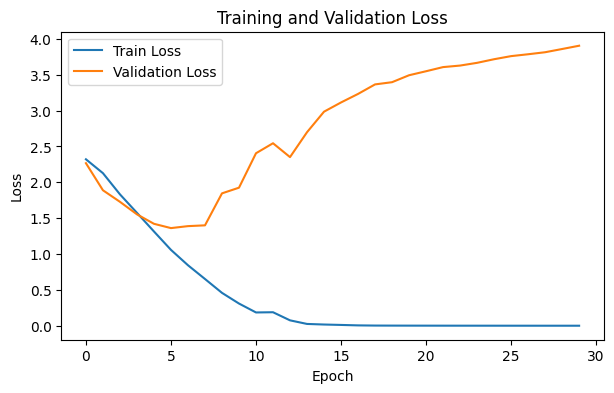

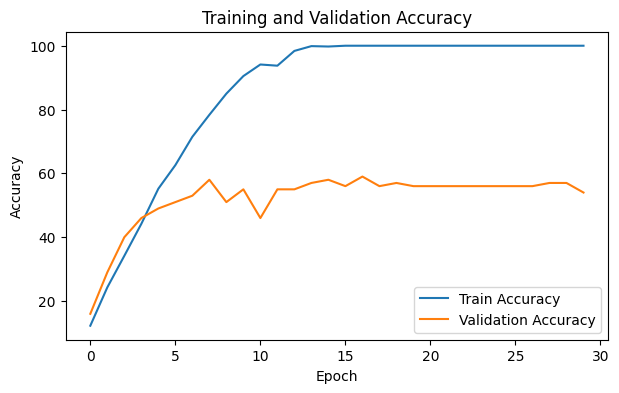

In [ ]:
# plot loss and accuracy curves
plt.figure(figsize=(7, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Observing the loss curves for training and validation, it is clear that the model overfitted after a few epochs.

### Evaluating the model

Evaluating the model in validation.

In [ ]:
y_pred = []
y_true = []

# iterate over val data
for inputs, labels in val_loader:
    # inputs = inputs.view(inputs.size(0), -1)
    inputs = inputs.view(inputs.size(0), 3, image_size, image_size)

    output = model_cnn(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

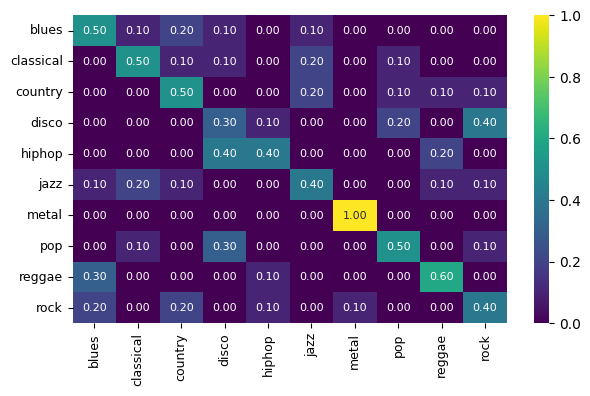

In [ ]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (7,4))
heatmap = sn.heatmap(df_cm, annot=True, cmap='viridis', fmt='.2f', annot_kws={"size": 8})
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=9)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=9)
plt.show()

Observing the confusion matrix, it is evident that the model performed well only for one class, `metal`, and for the other classes it was unable to capture relevant information for discrimination.

This behavior is expected since it was trained on a non-complex model.

In [ ]:
# calculate balanced accuracy
balanced_acc = balanced_accuracy_score(y_true, y_pred)
# acc = accuracy_score(y_true, y_pred)
print(f'Balanced Accuracy: {balanced_acc:.4f}')
# print(f'Accuracy: {acc:.4f}')

# calculete F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print('F1 Score: ', round(f1,4))

Balanced Accuracy: 0.5100
F1 Score:  0.5103


In [ ]:
all_labels = []
all_predictions = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.view(images.size(0), 3, image_size, image_size)
        outputs = model_cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.tolist())
        all_predictions.extend(predicted.tolist())

print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       0.45      0.50      0.48        10
           1       0.56      0.50      0.53        10
           2       0.45      0.50      0.48        10
           3       0.25      0.30      0.27        10
           4       0.57      0.40      0.47        10
           5       0.44      0.40      0.42        10
           6       0.91      1.00      0.95        10
           7       0.56      0.50      0.53        10
           8       0.60      0.60      0.60        10
           9       0.36      0.40      0.38        10

    accuracy                           0.51       100
   macro avg       0.52      0.51      0.51       100
weighted avg       0.52      0.51      0.51       100



Within its limitations, considering the number of classes and complexity of the model, baseline even performed good results, presenting an accuracy of just over 50%.

### Softmax Classifier

Simple Softmax classification model using a single linear layer was used.

In [ ]:
# build custom softmax module
class Softmax(torch.nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Softmax, self).__init__()
        self.linear = torch.nn.Linear(n_inputs, n_outputs)

    def forward(self, x):
        pred = self.linear(x)
        return pred

# call Softmax Classifier
n_inputs = image_size * image_size * 3
model_softmax = Softmax(n_inputs, numclass)
# model_softmax.state_dict()

Learning rate of 0.01 will be considered and optimizer Stochastic gradient descent (SGD).

In [ ]:
# define loss, optimizier, and dataloader for train and validation sets
optimizer = torch.optim.SGD(model_softmax.parameters(), lr = 0.01)
criterion = torch.nn.CrossEntropyLoss()

### Training the model

In [ ]:
epochs = 200
Loss = []
acc = []
val_losses = []

for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model_softmax(images.view(-1, n_inputs))
        loss = criterion(outputs, labels)
        # Loss.append(loss.item())
        loss.backward()
        optimizer.step()
    Loss.append(loss.item())

    # validation
    correct = 0
    total = 0
    val_loss = 0
    for images, labels in val_loader:
        outputs = model_softmax(images.view(-1, n_inputs))
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    accuracy = 100 * (correct.item()) / total
    acc.append(accuracy)
    if epoch % 10 == 0:
        print('Epoch: {}. Loss Training: {}. Loss Validation: {}. Accuracy: {}'.format(epoch, loss.item(), val_loss, accuracy))

Epoch: 0. Loss Training: 217.8192901611328. Loss Validation: 238.1956008911133. Accuracy: 16.0
Epoch: 10. Loss Training: 153.3038787841797. Loss Validation: 146.66540985107423. Accuracy: 22.0
Epoch: 20. Loss Training: 44.370338439941406. Loss Validation: 100.01206092834472. Accuracy: 39.0
Epoch: 30. Loss Training: 69.74573516845703. Loss Validation: 95.6895263671875. Accuracy: 35.0
Epoch: 40. Loss Training: 41.670799255371094. Loss Validation: 84.79022483825683. Accuracy: 33.0
Epoch: 50. Loss Training: 51.892364501953125. Loss Validation: 74.52342643737794. Accuracy: 41.0
Epoch: 60. Loss Training: 39.4935188293457. Loss Validation: 61.031225967407224. Accuracy: 38.0
Epoch: 70. Loss Training: 28.33097267150879. Loss Validation: 60.96480026245117. Accuracy: 39.0
Epoch: 80. Loss Training: 89.55406951904297. Loss Validation: 104.21985740661621. Accuracy: 32.0
Epoch: 90. Loss Training: 36.07123565673828. Loss Validation: 93.62359504699707. Accuracy: 36.0
Epoch: 100. Loss Training: 8.9985227

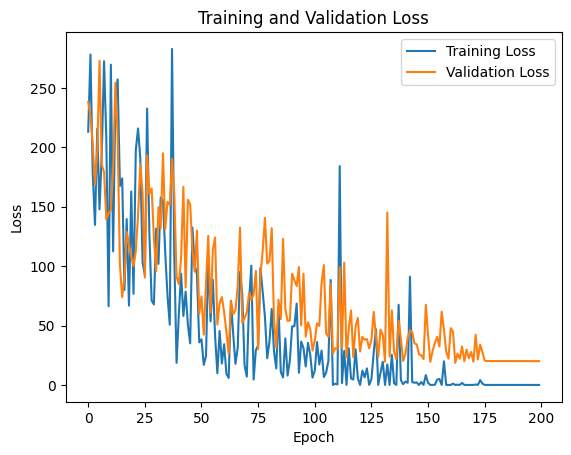

In [ ]:
# plot loss curves
plt.plot(Loss, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

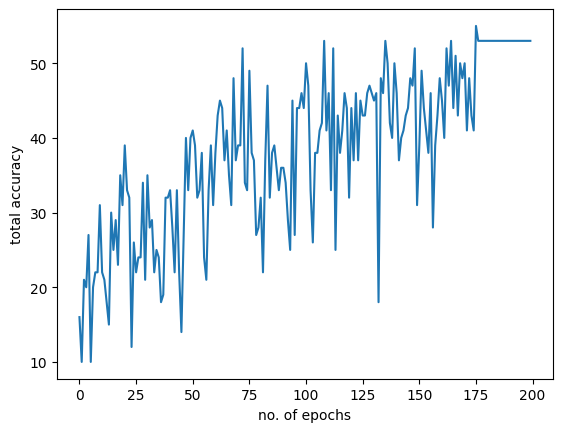

In [ ]:
# plot accuracy curve
plt.plot(acc)
plt.xlabel("no. of epochs")
plt.ylabel("total accuracy")
plt.show()

Observing the loss curves for training and validation, even with many epochs, the model did not suffer from overfitting and did not exceed 53% accuracy.

### Evaluating the model

Evaluating the model in validation.

In [ ]:
y_pred = []
y_true = []

# iterate over val data
for inputs, labels in val_loader:
    inputs = inputs.view(inputs.size(0), -1)

    output = model_softmax(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

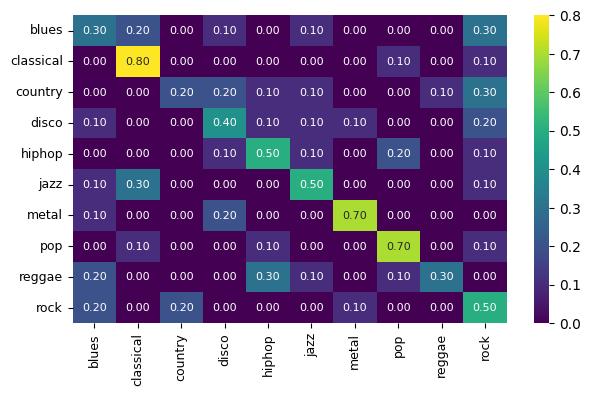

In [ ]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (7,4))
heatmap = sn.heatmap(df_cm, annot=True, cmap='viridis', fmt='.2f', annot_kws={"size": 8})
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=9)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=9)
plt.show()

Observing the confusion matrix, the model performed well for three classes, classical, metal and pop, and for the other classes it was unable to capture relevant information for discrimination, performing poorly.

This behavior is expected as it was trained on a non-complex model.

In [ ]:
# calculate balanced accuracy
balanced_acc = balanced_accuracy_score(y_true, y_pred)
# acc = accuracy_score(y_true, y_pred)
print(f'Balanced Accuracy: {balanced_acc:.4f}')
# print(f'Accuracy: {acc:.4f}')

# calculete F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print('F1 Score: ', round(f1,4))

Balanced Accuracy: 0.4900
F1 Score:  0.4831


In [ ]:
all_labels = []
all_predictions = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.view(images.size(0), 3, image_size, image_size)
        outputs = model_softmax(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.tolist())
        all_predictions.extend(predicted.tolist())

print(classification_report(all_labels, all_predictions))

Within its limitations, considering the number of classes, the complexity of the model, the model had only one linear layer until it presented some results, but worse than the baseline. Although it managed to learn more classes, it performed poorly for the others, almost random for the `country`, `blues` and `reggae` classes.

The simple sofmax showed an accuracy of just under 50%.

## Pre-trained Model through Transfer Learning

Pre- trained model with timm.

The main objective of using pre-trained models through transfer learning is to use the knowledge acquired by them and adapt to our needs, saving time and computational resources.

In [ ]:
try:
    import timm
except ImportError:
   ! pip install timm
   import timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

### Resnet50

Resnet50 has 50 layers deep and is considered an excellent image classification model, in addition to being able to obtain good results.

In the first Resnet50 approach, only the output layer was replaced and trained with the addition of a linear layer, ReLU activation function and 50% dropout, followed by the output of size 10 (number of classes).

In [ ]:
# load pre-trained model from timm
model_resnet50 = timm.create_model('resnet50', pretrained=True)

# modify the model head for fine-tuning
num_features = model_resnet50.fc.in_features

# additional linear layer and dropout layer
model_resnet50.fc = nn.Sequential(
    # additional linear layer with 256 output features
    nn.Linear(num_features, 256),
    # activation function
    nn.ReLU(inplace=True),
    # dropout 50%
    nn.Dropout(0.5),
    nn.Linear(256, numclass)
)

In [ ]:
print(model_resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

Learning rate of 0.001 will be considered and optimizer Adam.

In [ ]:
# defining the model
model = model_resnet50

# defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Training the model

In [ ]:
num_epochs = 10
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy.append(correct / total)
    train_losses.append(train_loss)

    # evaluate the model on the validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        val_running_loss = 0.0
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()

    val_loss /= len(test_loader)
    val_accuracy.append(correct / total)
    val_losses.append(val_loss)

    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy[-1]:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy[-1]:.4f}')

 10%|█         | 1/10 [01:21<12:13, 81.55s/it]

Training Loss: 2.1328, Training Accuracy: 0.2003, Validation Loss: 0.1759, Validation Accuracy: 0.3000


 20%|██        | 2/10 [02:42<10:47, 80.93s/it]

Training Loss: 1.6973, Training Accuracy: 0.3942, Validation Loss: 0.2252, Validation Accuracy: 0.4400


 30%|███       | 3/10 [04:01<09:22, 80.30s/it]

Training Loss: 1.3883, Training Accuracy: 0.5257, Validation Loss: 0.2109, Validation Accuracy: 0.2700


 40%|████      | 4/10 [05:21<07:59, 79.98s/it]

Training Loss: 1.2428, Training Accuracy: 0.5795, Validation Loss: 0.0559, Validation Accuracy: 0.6000


 50%|█████     | 5/10 [06:41<06:39, 79.97s/it]

Training Loss: 1.0550, Training Accuracy: 0.6646, Validation Loss: 0.1111, Validation Accuracy: 0.6100


 60%|██████    | 6/10 [08:01<05:20, 80.24s/it]

Training Loss: 0.8130, Training Accuracy: 0.7434, Validation Loss: 0.1229, Validation Accuracy: 0.6100


 70%|███████   | 7/10 [09:22<04:00, 80.25s/it]

Training Loss: 0.6987, Training Accuracy: 0.7622, Validation Loss: 0.1065, Validation Accuracy: 0.5600


 80%|████████  | 8/10 [10:41<02:40, 80.06s/it]

Training Loss: 0.6147, Training Accuracy: 0.8035, Validation Loss: 0.0649, Validation Accuracy: 0.6500


 90%|█████████ | 9/10 [12:02<01:20, 80.22s/it]

Training Loss: 0.5006, Training Accuracy: 0.8448, Validation Loss: 0.0491, Validation Accuracy: 0.6300


100%|██████████| 10/10 [13:21<00:00, 80.19s/it]

Training Loss: 0.3845, Training Accuracy: 0.8811, Validation Loss: 0.0904, Validation Accuracy: 0.6400


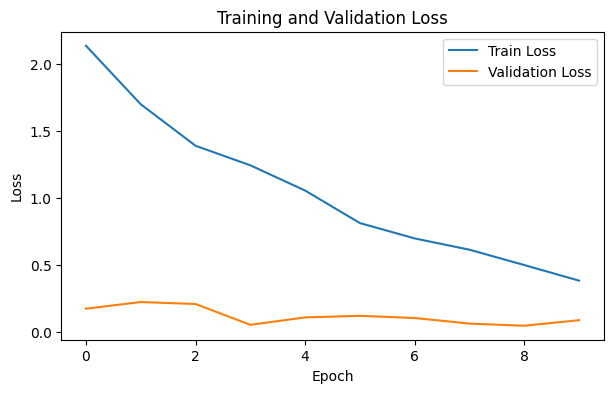

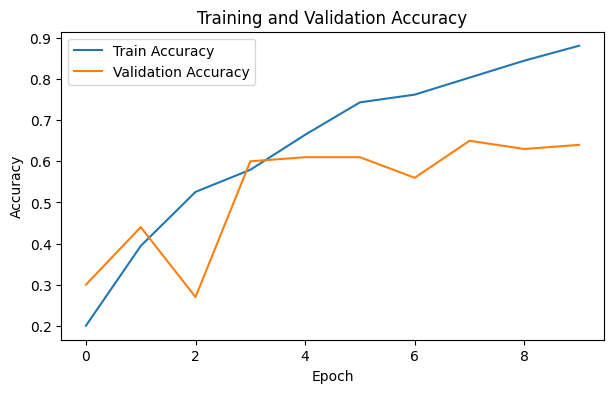

In [ ]:
# plot loss and accuracy curves
plt.figure(figsize=(7, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Observing the loss curves for training and validation, after 10 epochs the model did not suffer from overfitting but it appears that it will suffer with more epochs. Training accuracy increases and in validation it does not exceed 65%, which may indicate future overfitting.

### Evaluating the model

Evaluating the model in validation.

In [ ]:
y_pred = []
y_true = []

# iterate over val data
for inputs, labels in val_loader:
    # inputs = inputs.view(inputs.size(0), -1)
    inputs = inputs.view(inputs.size(0), 3, image_size, image_size)

    output = model(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

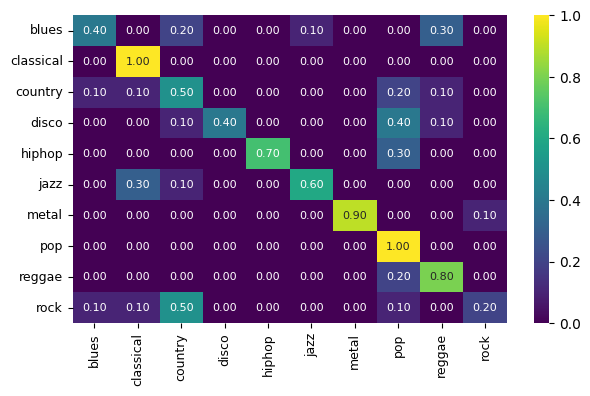

In [ ]:
# build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (7,4))
heatmap = sn.heatmap(df_cm, annot=True, cmap='viridis', fmt='.2f', annot_kws={"size": 8})
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=9)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=9)
plt.show()

Observing the confusion matrix, we see that the model shows improvement compared to previous simpler networks. The model performed well for the classes `classical`, `pop`, `metal`, `reggae` and `hiphop`, respectively. For the other classes it was unable to capture relevant information for discrimination, presenting the worst performance for `rock`.

In [ ]:
# calculate balanced accuracy
balanced_acc = balanced_accuracy_score(y_true, y_pred)
# acc = accuracy_score(y_true, y_pred)
print(f'Balanced Accuracy: {balanced_acc:.4f}')
# print(f'Accuracy: {acc:.4f}')

# calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print('F1 Score: ', round(f1,4))

Balanced Accuracy: 0.6500
F1 Score:  0.6393


In [ ]:
all_labels = []
all_predictions = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.view(images.size(0), 3, image_size, image_size)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.tolist())
        all_predictions.extend(predicted.tolist())

print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       0.67      0.40      0.50        10
           1       0.67      1.00      0.80        10
           2       0.36      0.50      0.42        10
           3       1.00      0.40      0.57        10
           4       1.00      0.70      0.82        10
           5       0.86      0.60      0.71        10
           6       1.00      0.90      0.95        10
           7       0.45      1.00      0.62        10
           8       0.62      0.80      0.70        10
           9       0.67      0.20      0.31        10

    accuracy                           0.65       100
   macro avg       0.73      0.65      0.64       100
weighted avg       0.73      0.65      0.64       100



Compared to previous models, the use of pre-trained models to improve performance achieved good results, but the model was still unable to learn some classes, such as `rock`.

Overall, it achieved 65% accuracy.

### Xception

Xception is a deep convolutional neural network known for its novel feature learning. The model presents a different architecture resulting in a smaller number of parameters but still maintaining performance.

In the first Xception approach, we maintain the same approach as Resnet50, only the output layer was replaced and trained by adding a linear layer, ReLU activation function and 50% dropout, followed by the output of size 10 (number of classes).

In [ ]:
# load pre-trained model from timm
model_xception = timm.create_model('xception', pretrained=True)

# modify the model head for fine-tuning
num_features = model_xception.fc.in_features

# additional linear layer and dropout layer
model_xception.fc = nn.Sequential(
    # additional linear layer with 256 output features
    nn.Linear(num_features, 256),
    # activation function
    nn.ReLU(inplace=True),
    # dropout 50%
    nn.Dropout(0.5),
    nn.Linear(256, numclass)
)

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


In [ ]:
print(model_xception)

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

Learning rate of 0.001 will be considered and optimizer Adam.

In [ ]:
# defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_xception.parameters(), lr=0.001)

#### Training the model

In [ ]:
num_epochs = 10
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

for epoch in tqdm(range(num_epochs)):
    model_xception.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_xception(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy.append(correct / total)
    train_losses.append(train_loss)

    # evaluate the model on the validation
    model_xception.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        val_running_loss = 0.0
        for images, labels in test_loader:
            outputs = model_xception(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()

    val_loss /= len(test_loader)
    val_accuracy.append(correct / total)
    val_losses.append(val_loss)

    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy[-1]:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy[-1]:.4f}')

 10%|█         | 1/10 [05:25<48:51, 325.71s/it]

Training Loss: 2.1489, Training Accuracy: 0.2053, Validation Loss: 0.2411, Validation Accuracy: 0.2500


 20%|██        | 2/10 [07:41<28:31, 213.94s/it]

Training Loss: 1.8479, Training Accuracy: 0.3141, Validation Loss: 0.1483, Validation Accuracy: 0.3600


 30%|███       | 3/10 [09:50<20:27, 175.40s/it]

Training Loss: 1.6998, Training Accuracy: 0.3191, Validation Loss: 0.1474, Validation Accuracy: 0.4400


 40%|████      | 4/10 [12:07<16:01, 160.25s/it]

Training Loss: 1.6725, Training Accuracy: 0.3792, Validation Loss: 0.1184, Validation Accuracy: 0.4600


 50%|█████     | 5/10 [14:22<12:34, 150.93s/it]

Training Loss: 1.5782, Training Accuracy: 0.4280, Validation Loss: 0.1734, Validation Accuracy: 0.3900


 60%|██████    | 6/10 [16:53<10:04, 151.09s/it]

Training Loss: 1.3881, Training Accuracy: 0.4919, Validation Loss: 0.0629, Validation Accuracy: 0.6000


 70%|███████   | 7/10 [19:17<07:26, 148.79s/it]

Training Loss: 1.3763, Training Accuracy: 0.4869, Validation Loss: 0.1174, Validation Accuracy: 0.5200


 80%|████████  | 8/10 [21:36<04:51, 145.58s/it]

Training Loss: 1.2164, Training Accuracy: 0.5582, Validation Loss: 0.1467, Validation Accuracy: 0.5700


 90%|█████████ | 9/10 [23:45<02:20, 140.42s/it]

Training Loss: 0.9667, Training Accuracy: 0.6633, Validation Loss: 0.1024, Validation Accuracy: 0.6000


100%|██████████| 10/10 [25:56<00:00, 155.61s/it]

Training Loss: 0.8909, Training Accuracy: 0.6859, Validation Loss: 0.1381, Validation Accuracy: 0.5100


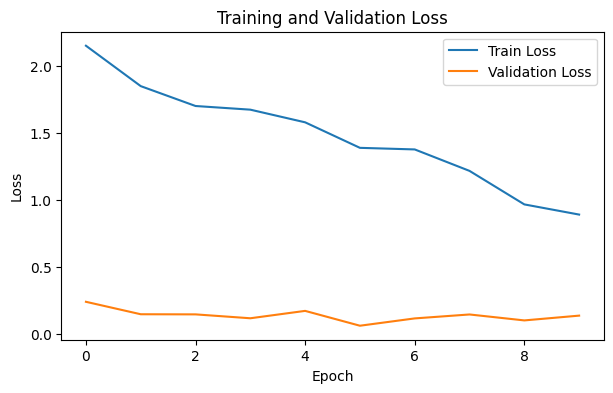

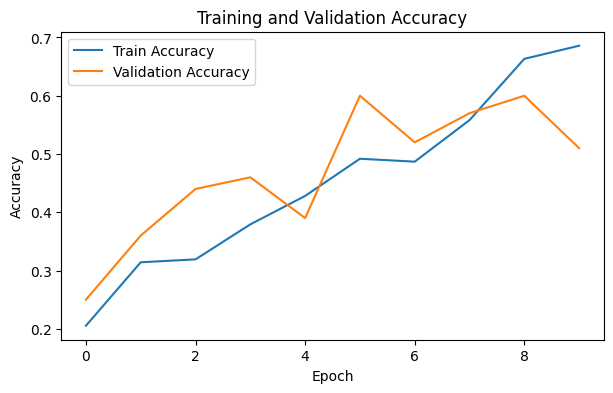

In [ ]:
# plot loss and accuracy curves
plt.figure(figsize=(7, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Observing the loss curves for training and validation, after 10 epochs the model did not suffer from overfitting and it seems that it is still possible to train more epochs before overfitting. Training and validation accuracy increases, reaching 60% in validation.

#### Evaluating the model

Evaluating the model in validation.

In [ ]:
y_pred = []
y_true = []

# iterate over val data
for inputs, labels in val_loader:
    # inputs = inputs.view(inputs.size(0), -1)
    inputs = inputs.view(inputs.size(0), 3, image_size, image_size)

    output = model_xception(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

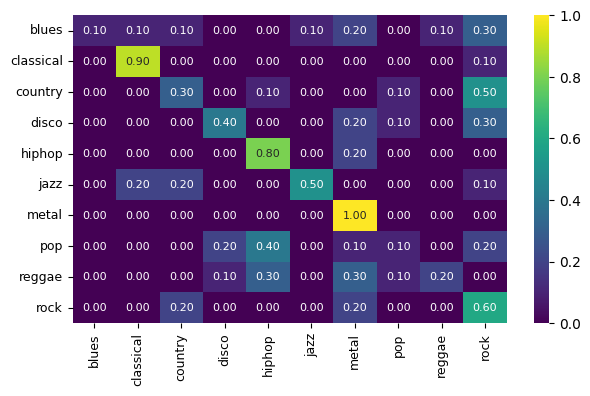

In [ ]:
# build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (7,4))
heatmap = sn.heatmap(df_cm, annot=True, cmap='viridis', fmt='.2f', annot_kws={"size": 8})
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=9)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=9)
plt.show()

Looking at the confusion matrix, the model does not seem to be better than the previous ones, including the simplest models, such as baseline. It only had good results for three classes, `metal`, `classical` and `hiphop`. For the other classes it performed poorly, especially for the `blues` and `pop` classes, which proved to be completely random.

In [ ]:
# calculate balanced accuracy
balanced_acc = balanced_accuracy_score(y_true, y_pred)
# acc = accuracy_score(y_true, y_pred)
print(f'Balanced Accuracy: {balanced_acc:.4f}')
# print(f'Accuracy: {acc:.4f}')

# calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print('F1 Score: ', round(f1,4))

Balanced Accuracy: 0.4900
F1 Score:  0.4507


In [ ]:
all_labels = []
all_predictions = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.view(images.size(0), 3, image_size, image_size)
        outputs = model_xception(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.tolist())
        all_predictions.extend(predicted.tolist())

print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       1.00      0.10      0.18        10
           1       0.75      0.90      0.82        10
           2       0.38      0.30      0.33        10
           3       0.57      0.40      0.47        10
           4       0.50      0.80      0.62        10
           5       0.83      0.50      0.62        10
           6       0.45      1.00      0.62        10
           7       0.25      0.10      0.14        10
           8       0.67      0.20      0.31        10
           9       0.29      0.60      0.39        10

    accuracy                           0.49       100
   macro avg       0.57      0.49      0.45       100
weighted avg       0.57      0.49      0.45       100



Compared to previous models, the model was unable to learn some classes well and capture the characteristics of each class, achieving less than 50% accuracy.


### Xception 2

The second Xception approach, only the output layer of size 10 (number of classes) and the learning rate were changed.

In [ ]:
# Load pre-trained model from timm
model_xception2 = timm.create_model('xception', pretrained=True)

# Modify the model head for fine-tuning
num_features = model_xception2.fc.in_features
model_xception2.fc = nn.Linear(num_features, numclass)

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [ ]:
print(model_xception2)

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

Learning rate of 0.0001 will be considered and optimizer Adam.

In [ ]:
# defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_xception2.parameters(), lr=0.0001)

#### Training the model

In [ ]:
num_epochs = 10
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

for epoch in tqdm(range(num_epochs)):
    model_xception2.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_xception2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy.append(correct / total)
    train_losses.append(train_loss)

    # evaluate the model on the validation
    model_xception2.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        val_running_loss = 0.0
        for images, labels in test_loader:
            outputs = model_xception2(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()

    val_loss /= len(test_loader)
    val_accuracy.append(correct / total)
    val_losses.append(val_loss)

    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy[-1]:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy[-1]:.4f}')

 10%|█         | 1/10 [02:08<19:20, 128.97s/it]

Training Loss: 1.8595, Training Accuracy: 0.4093, Validation Loss: 0.1110, Validation Accuracy: 0.6300


 20%|██        | 2/10 [04:18<17:16, 129.56s/it]

Training Loss: 1.0254, Training Accuracy: 0.7034, Validation Loss: 0.0866, Validation Accuracy: 0.7400


 30%|███       | 3/10 [06:31<15:16, 130.94s/it]

Training Loss: 0.5796, Training Accuracy: 0.8398, Validation Loss: 0.0443, Validation Accuracy: 0.7800


 40%|████      | 4/10 [08:42<13:06, 131.04s/it]

Training Loss: 0.3485, Training Accuracy: 0.9099, Validation Loss: 0.0294, Validation Accuracy: 0.7200


 50%|█████     | 5/10 [10:54<10:55, 131.16s/it]

Training Loss: 0.2338, Training Accuracy: 0.9499, Validation Loss: 0.0679, Validation Accuracy: 0.7200


 60%|██████    | 6/10 [13:07<08:47, 131.78s/it]

Training Loss: 0.1439, Training Accuracy: 0.9687, Validation Loss: 0.1097, Validation Accuracy: 0.7400


 70%|███████   | 7/10 [15:19<06:35, 131.95s/it]

Training Loss: 0.1258, Training Accuracy: 0.9687, Validation Loss: 0.0413, Validation Accuracy: 0.7300


 80%|████████  | 8/10 [17:34<04:25, 132.99s/it]

Training Loss: 0.1320, Training Accuracy: 0.9662, Validation Loss: 0.0063, Validation Accuracy: 0.6900


 90%|█████████ | 9/10 [20:05<02:18, 138.67s/it]

Training Loss: 0.1165, Training Accuracy: 0.9762, Validation Loss: 0.0788, Validation Accuracy: 0.7500


100%|██████████| 10/10 [22:18<00:00, 133.86s/it]

Training Loss: 0.0702, Training Accuracy: 0.9887, Validation Loss: 0.0548, Validation Accuracy: 0.7300


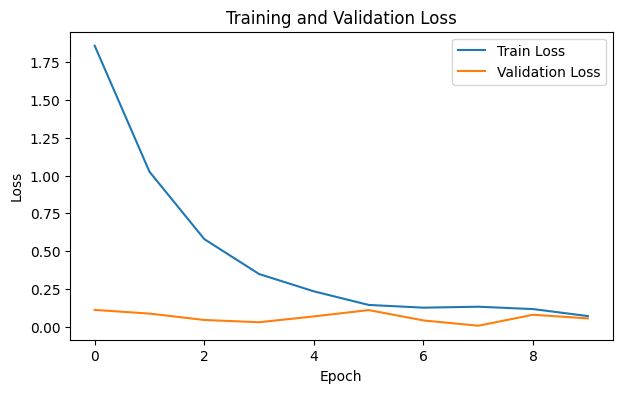

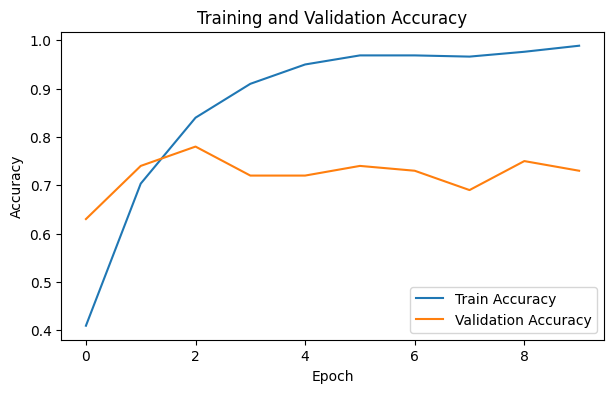

In [ ]:
# plot loss and accuracy curves
plt.figure(figsize=(7, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Observing the loss curves for training and validation, after 10 epochs the model did not suffer from overfitting but it appears that it will suffer with more epochs. Training accuracy increases and in validation it remains constant, not exceeding 78%, which may indicate future overfitting.

#### Evaluating the model

Evaluating the model in validation.

In [ ]:
y_pred = []
y_true = []

# iterate over val data
for inputs, labels in val_loader:
    # inputs = inputs.view(inputs.size(0), -1)
    inputs = inputs.view(inputs.size(0), 3, image_size, image_size)

    output = model_xception2(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

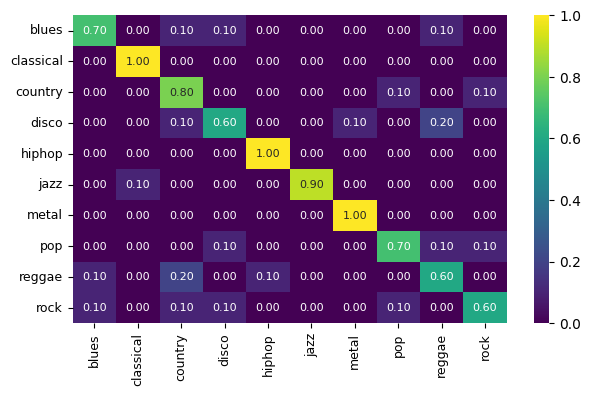

In [ ]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (7,4))
heatmap = sn.heatmap(df_cm, annot=True, cmap='viridis', fmt='.2f', annot_kws={"size": 8})
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=9)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=9)
plt.show()

Observing the confusion matrix, we see that the model presents improvements in relation to the previous simpler networks and the Resnet50 model. The model performed well in seven different classes, `classical`, `hiphop`, `metal`, `jazz`, `country`, `blues` and `pop` classes, respectively. For the other classes, he achieved a 60% accuracy rate, demonstrating that he was able to capture relevant information for discrimination. No class performed poorly.


In [ ]:
# calculate balanced accuracy
balanced_acc = balanced_accuracy_score(y_true, y_pred)
# acc = accuracy_score(y_true, y_pred)
print(f'Balanced Accuracy: {balanced_acc:.4f}')
# print(f'Accuracy: {acc:.4f}')

# calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print('F1 Score: ', round(f1,4))

Balanced Accuracy: 0.7900
F1 Score:  0.7872


In [ ]:
all_labels = []
all_predictions = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.view(images.size(0), 3, image_size, image_size)
        outputs = model_xception2(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.tolist())
        all_predictions.extend(predicted.tolist())

print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.91      1.00      0.95        10
           2       0.62      0.80      0.70        10
           3       0.67      0.60      0.63        10
           4       0.91      1.00      0.95        10
           5       1.00      0.90      0.95        10
           6       0.91      1.00      0.95        10
           7       0.78      0.70      0.74        10
           8       0.60      0.60      0.60        10
           9       0.75      0.60      0.67        10

    accuracy                           0.79       100
   macro avg       0.79      0.79      0.79       100
weighted avg       0.79      0.79      0.79       100



Compared to previous models, the Xception model, just modifying the last layer, showed good results, the best to date.
It got 79% accuracy.

### Xception 3

In the third Xception approach, the same previous model was maintained with only the output layer of size 10 (number of classes) and the learning rate were changed, learning rate of 0.001.

In [ ]:
# load pre-trained model from timm
model_xception3 = timm.create_model('xception', pretrained=True)

# modify the model head for fine-tuning
num_features = model_xception3.fc.in_features
model_xception3.fc = nn.Linear(num_features, numclass)

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [ ]:
print(model_xception3)

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

Learning rate of 0.001 will be considered and optimizer Adam.

In [ ]:
# defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_xception3.parameters(), lr=0.001)

#### Training the model

In [ ]:
num_epochs = 10
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

for epoch in tqdm(range(num_epochs)):
    model_xception3.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_xception3(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy.append(correct / total)
    train_losses.append(train_loss)

    # evaluate the model on the validation
    model_xception3.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        val_running_loss = 0.0
        for images, labels in test_loader:
            outputs = model_xception3(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()

    val_loss /= len(test_loader)
    val_accuracy.append(correct / total)
    val_losses.append(val_loss)

    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy[-1]:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy[-1]:.4f}')

 10%|█         | 1/10 [02:33<22:58, 153.18s/it]

Training Loss: 1.7936, Training Accuracy: 0.3705, Validation Loss: 0.1619, Validation Accuracy: 0.3500


 20%|██        | 2/10 [04:48<19:02, 142.85s/it]

Training Loss: 1.4929, Training Accuracy: 0.4906, Validation Loss: 0.1011, Validation Accuracy: 0.5500


 30%|███       | 3/10 [07:02<16:11, 138.81s/it]

Training Loss: 1.1559, Training Accuracy: 0.6133, Validation Loss: 0.0718, Validation Accuracy: 0.6600


 40%|████      | 4/10 [09:16<13:40, 136.75s/it]

Training Loss: 0.9336, Training Accuracy: 0.6846, Validation Loss: 0.1218, Validation Accuracy: 0.5700


 50%|█████     | 5/10 [11:30<11:18, 135.77s/it]

Training Loss: 0.7602, Training Accuracy: 0.7209, Validation Loss: 0.1359, Validation Accuracy: 0.4900


 60%|██████    | 6/10 [13:45<09:02, 135.55s/it]

Training Loss: 0.5072, Training Accuracy: 0.8223, Validation Loss: 0.1303, Validation Accuracy: 0.5400


 70%|███████   | 7/10 [15:58<06:44, 134.75s/it]

Training Loss: 0.4593, Training Accuracy: 0.8511, Validation Loss: 0.1142, Validation Accuracy: 0.6400


 80%|████████  | 8/10 [18:13<04:29, 134.81s/it]

Training Loss: 0.4152, Training Accuracy: 0.8573, Validation Loss: 0.0143, Validation Accuracy: 0.6900


 90%|█████████ | 9/10 [20:28<02:14, 134.98s/it]

Training Loss: 0.3096, Training Accuracy: 0.8999, Validation Loss: 0.0272, Validation Accuracy: 0.6200


100%|██████████| 10/10 [22:44<00:00, 136.46s/it]

Training Loss: 0.1656, Training Accuracy: 0.9487, Validation Loss: 0.0261, Validation Accuracy: 0.6600


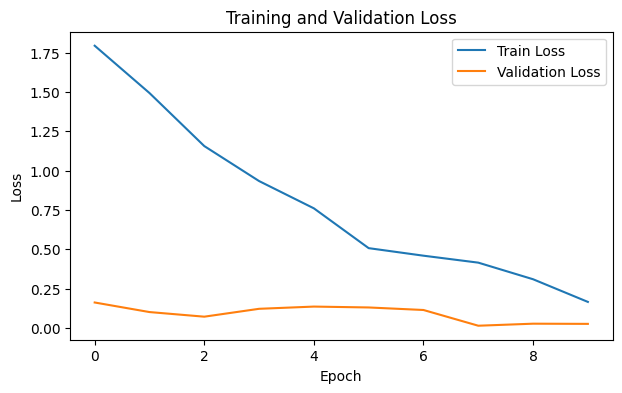

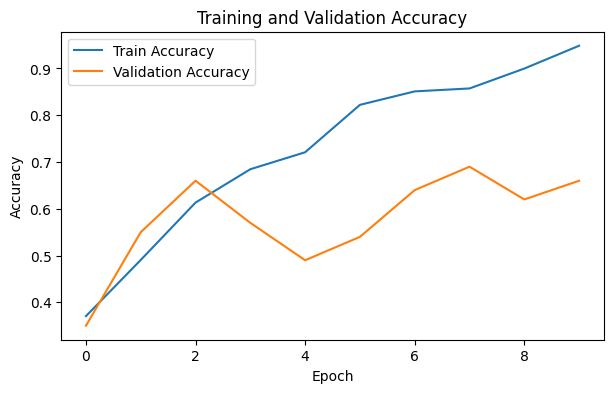

In [ ]:
# plot loss and accuracy curves
plt.figure(figsize=(7, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Observing the loss curves for training and validation, after 10 epochs the model did not suffer from overfitting but it appears that it will suffer with more epochs. Training accuracy increases and in validation reaching 69%, which may indicate future overfitting.

#### Evaluating the model

Evaluating the model in validation.

In [ ]:
y_pred = []
y_true = []

# iterate over val data
for inputs, labels in val_loader:
    # inputs = inputs.view(inputs.size(0), -1)
    inputs = inputs.view(inputs.size(0), 3, image_size, image_size)

    output = model_xception3(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

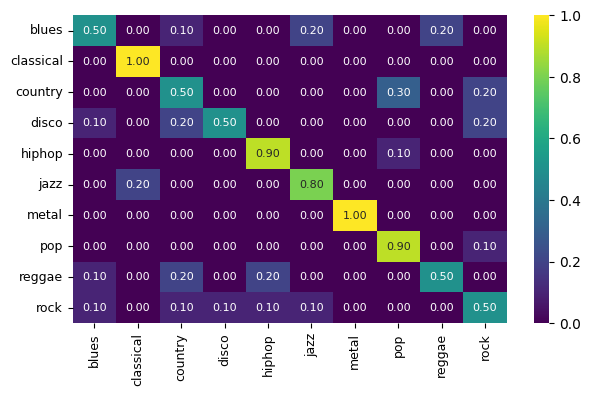

In [ ]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (7,4))
heatmap = sn.heatmap(df_cm, annot=True, cmap='viridis', fmt='.2f', annot_kws={"size": 8})
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=9)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=9)
plt.show()

Observing the confusion matrix, we see that the model performs well in five classes, `classical`, `metal`, `hiphop`, `pop` and `jazz`, respectively. For the other classes it obtained a reasonable performance, but still confusing with other classes. No class performed poorly.

In [ ]:
# calculate balanced accuracy
balanced_acc = balanced_accuracy_score(y_true, y_pred)
# acc = accuracy_score(y_true, y_pred)
print(f'Balanced Accuracy: {balanced_acc:.4f}')
# print(f'Accuracy: {acc:.4f}')

# calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print('F1 Score: ', round(f1,4))

Balanced Accuracy: 0.7100
F1 Score:  0.7017


In [ ]:
all_labels = []
all_predictions = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.view(images.size(0), 3, image_size, image_size)
        outputs = model_xception3(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.tolist())
        all_predictions.extend(predicted.tolist())

print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       0.62      0.50      0.56        10
           1       0.83      1.00      0.91        10
           2       0.45      0.50      0.48        10
           3       0.83      0.50      0.62        10
           4       0.75      0.90      0.82        10
           5       0.73      0.80      0.76        10
           6       1.00      1.00      1.00        10
           7       0.69      0.90      0.78        10
           8       0.71      0.50      0.59        10
           9       0.50      0.50      0.50        10

    accuracy                           0.71       100
   macro avg       0.71      0.71      0.70       100
weighted avg       0.71      0.71      0.70       100



Overall, the model achieved good results, but not better than the previous model with the same architecture and different learning rate. It achieved 71% accuracy.

## Resnet50 2

Given that the Xception models performed better by changing only the last output, the same technique will be tested however with the Resnet50 model, it means, it was maintained with only the output layer of size 10 (number of classes).

In [ ]:
model_resnet50 = timm.create_model('resnet50', pretrained=True)

for param in model_resnet50.fc.parameters():
    param.requires_grad = False #True

In [ ]:
num_ftrs = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_ftrs, numclass)

Learning rate of 0.001 will be considered and optimizer Adam.

In [ ]:
# defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet50.parameters(), lr=0.001)

#### Training the model

In [ ]:
num_epochs = 10
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

for epoch in tqdm(range(num_epochs)):
    model_resnet50.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_resnet50(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy.append(correct / total)
    train_losses.append(train_loss)

    # evaluate the model on the validation
    model_resnet50.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        val_running_loss = 0.0
        for images, labels in test_loader:
            outputs = model_resnet50(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()

    val_loss /= len(test_loader)
    val_accuracy.append(correct / total)
    val_losses.append(val_loss)

    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy[-1]:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy[-1]:.4f}')

 10%|█         | 1/10 [01:29<13:27, 89.74s/it]

Training Loss: 1.8836, Training Accuracy: 0.3379, Validation Loss: 0.1046, Validation Accuracy: 0.5100


 20%|██        | 2/10 [02:51<11:19, 84.93s/it]

Training Loss: 1.2940, Training Accuracy: 0.5582, Validation Loss: 0.1332, Validation Accuracy: 0.5200


 30%|███       | 3/10 [04:10<09:35, 82.24s/it]

Training Loss: 0.9412, Training Accuracy: 0.6733, Validation Loss: 0.0812, Validation Accuracy: 0.5300


 40%|████      | 4/10 [05:28<08:04, 80.79s/it]

Training Loss: 0.7649, Training Accuracy: 0.7459, Validation Loss: 0.0586, Validation Accuracy: 0.6800


 50%|█████     | 5/10 [06:55<06:54, 82.94s/it]

Training Loss: 0.5315, Training Accuracy: 0.8335, Validation Loss: 0.1034, Validation Accuracy: 0.5500


 60%|██████    | 6/10 [08:21<05:36, 84.02s/it]

Training Loss: 0.4726, Training Accuracy: 0.8473, Validation Loss: 0.0875, Validation Accuracy: 0.4600


 70%|███████   | 7/10 [09:40<04:06, 82.32s/it]

Training Loss: 0.3158, Training Accuracy: 0.9024, Validation Loss: 0.0242, Validation Accuracy: 0.6700


 80%|████████  | 8/10 [10:59<02:42, 81.18s/it]

Training Loss: 0.3316, Training Accuracy: 0.8936, Validation Loss: 0.0792, Validation Accuracy: 0.6400


 90%|█████████ | 9/10 [12:17<01:20, 80.31s/it]

Training Loss: 0.1757, Training Accuracy: 0.9462, Validation Loss: 0.0916, Validation Accuracy: 0.6700


100%|██████████| 10/10 [13:35<00:00, 81.57s/it]

Training Loss: 0.1953, Training Accuracy: 0.9437, Validation Loss: 0.0908, Validation Accuracy: 0.6200


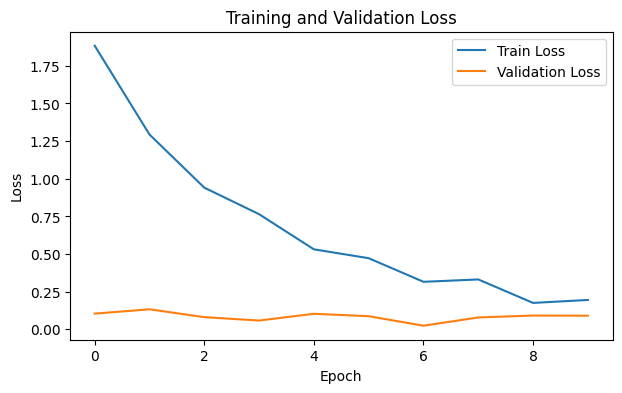

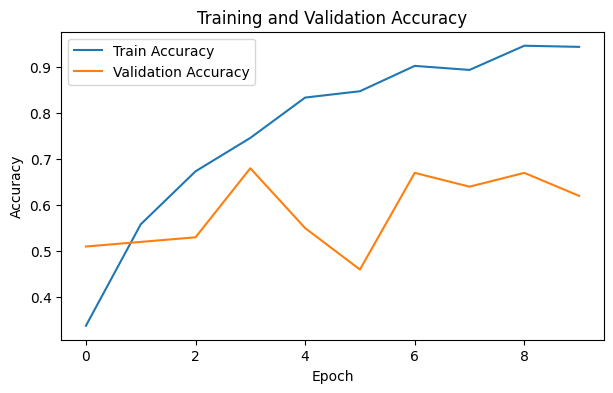

In [ ]:
# plot loss and accuracy curves
plt.figure(figsize=(7, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Observing the loss curves for training and validation, after 10 epochs the model did not suffer from overfitting but it appears that it will suffer with more epochs. Training accuracy increases and in validation it does not exceed 67%, which may indicate future overfitting.

#### Evaluating the model

Evaluating the model in validation.

In [ ]:
y_pred = []
y_true = []

# iterate over val data
for inputs, labels in val_loader:
    # inputs = inputs.view(inputs.size(0), -1)
    inputs = inputs.view(inputs.size(0), 3, image_size, image_size)

    output = model_resnet50(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

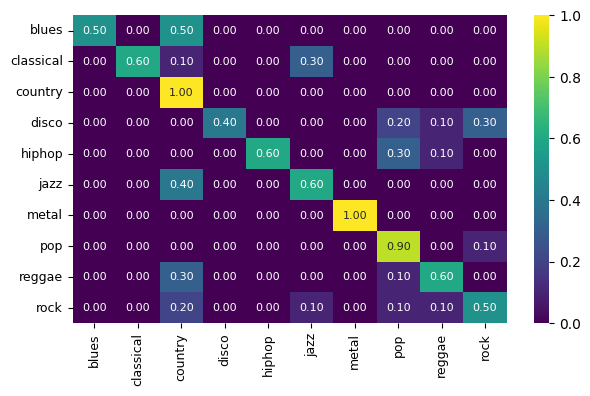

In [ ]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (7,4))
heatmap = sn.heatmap(df_cm, annot=True, cmap='viridis', fmt='.2f', annot_kws={"size": 8})
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=9)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=9)
plt.show()

Observing the confusion matrix, the model showed good results for three classes, `country`, `metal` and `pop`, respectively.
For the other classes it performed reasonably well, but still presents confusing classifications for some classes.

In [ ]:
# calculate balanced accuracy
balanced_acc = balanced_accuracy_score(y_true, y_pred)
# acc = accuracy_score(y_true, y_pred)
print(f'Balanced Accuracy: {balanced_acc:.4f}')
# print(f'Accuracy: {acc:.4f}')

# calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print('F1 Score: ', round(f1,4))

Balanced Accuracy: 0.6700
F1 Score:  0.676


In [ ]:
all_labels = []
all_predictions = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.view(images.size(0), 3, image_size, image_size)
        outputs = model_resnet50(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.tolist())
        all_predictions.extend(predicted.tolist())

print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       1.00      0.60      0.75        10
           2       0.40      1.00      0.57        10
           3       1.00      0.40      0.57        10
           4       1.00      0.60      0.75        10
           5       0.60      0.60      0.60        10
           6       1.00      1.00      1.00        10
           7       0.56      0.90      0.69        10
           8       0.67      0.60      0.63        10
           9       0.56      0.50      0.53        10

    accuracy                           0.67       100
   macro avg       0.78      0.67      0.68       100
weighted avg       0.78      0.67      0.68       100



Compared to previous models, the model did not present major improvements, obtaining 67% accuracy.

## Testing

Testing the best model in the test set.

Xception with output layer change of size 10 (number of classes) and learning rate of 0.0001.

In [ ]:
y_pred = []
y_true = []

# iterate over val data
for inputs, labels in test_loader:
    # inputs = inputs.view(inputs.size(0), -1)
    inputs = inputs.view(inputs.size(0), 3, image_size, image_size)

    output = model_xception2(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

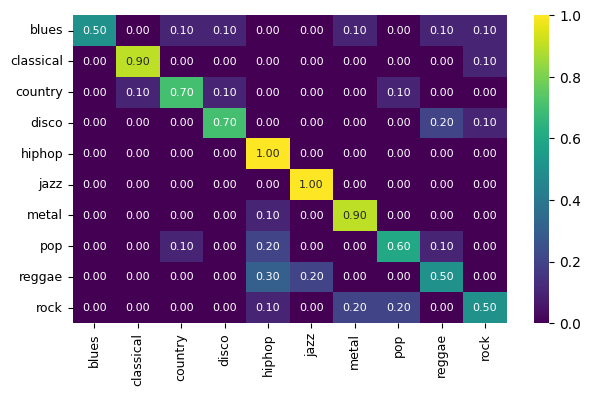

In [ ]:
# build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (7,4))
heatmap = sn.heatmap(df_cm, annot=True, cmap='viridis', fmt='.2f', annot_kws={"size": 8})
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=9)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=9)
plt.show()

Observing the confusion matrix in the test set, we see that the model presents good results in some classes, such as `hiphop`, `jazz`, `classical`, `metal`, `country` and `disco`, respectively. For the `blues`, `reggae` and `rock` classes, despite not presenting bad results, it presents some confusion in the classifications.

In [ ]:
# calculate balanced accuracy
balanced_acc = balanced_accuracy_score(y_true, y_pred)
# acc = accuracy_score(y_true, y_pred)
print(f'Balanced Accuracy: {balanced_acc:.4f}')
# print(f'Accuracy: {acc:.4f}')

# calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print('F1 Score: ', round(f1,4))

Balanced Accuracy: 0.7300
F1 Score:  0.7222


In [ ]:
all_labels = []
all_predictions = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(images.size(0), 3, image_size, image_size)
        outputs = model_xception2(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.tolist())
        all_predictions.extend(predicted.tolist())

print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.90      0.90      0.90        10
           2       0.78      0.70      0.74        10
           3       0.78      0.70      0.74        10
           4       0.59      1.00      0.74        10
           5       0.83      1.00      0.91        10
           6       0.75      0.90      0.82        10
           7       0.67      0.60      0.63        10
           8       0.56      0.50      0.53        10
           9       0.62      0.50      0.56        10

    accuracy                           0.73       100
   macro avg       0.75      0.73      0.72       100
weighted avg       0.75      0.73      0.72       100



Overall, the model obtained good results for the test data set, with a similar performance to the validation set. It achieved 73% accuracy.

### Conclusion

Comparing all the trained models, there is a difference between the techniques covered and the importance of refining the learning rate, which showed improvements in the model. Other approaches can be used to increase performance, such as reducing complexity by applying cuts to the Xception network, or using emsables, or testing other hyperparameters (learning rate or optimizer).

**Refereces:**

https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

https://discuss.pytorch.org/t/how-to-do-a-stratified-split/62290

https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7

https://rumn.medium.com/part-1-ultimate-guide-to-fine-tuning-in-pytorch-pre-trained-model-and-its-configuration-8990194b71e

https://github.com/huggingface/pytorch-image-models/tree/main/timm/models